### Patch Notes
- 2020-04-23 - Added Managers Data
- 2020-04-24 - Added season_offset function
- 2020-04-27 - Added Rolling Stats section, updated modelling results to save predictions and feature importances

## Reading in the data

In [1]:
import pandas as pd
import numpy as np
import re
# import os

# os.chdir('C:/Users/arpan/OneDrive/Desktop/Signus/Sports Betting/Analysis/')

In [2]:
# Read in the data
epl_data = pd.read_csv('../Data/EPL_Data_New.csv')
print(epl_data.shape)
epl_data.head()

(3800, 78)


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAvAHH,BbMxAHA,BbAvAHA,Season,PSH,PSD,PSA,PSCH,PSCD,PSCA
0,E0,2009-08-15,Aston Villa,Wigan,0,2,A,0,1,A,...,1.22,4.40,3.99,S0910,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,2009-08-15,Blackburn,Man City,0,2,A,0,1,A,...,2.38,1.60,1.54,S0910,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,2009-08-15,Bolton,Sunderland,0,1,A,0,1,A,...,1.61,2.33,2.23,S0910,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,2009-08-15,Chelsea,Hull,2,1,H,1,1,D,...,1.02,17.05,12.96,S0910,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,2009-08-15,Everton,Arsenal,1,6,A,0,3,A,...,2.20,1.73,1.63,S0910,NaN,NaN,NaN,NaN,NaN,NaN


# FEATURE ENGINEERING

### Train - Validation - Test Split

In [5]:
# Convert Date column to pandas datetime format
epl_data.Date = pd.to_datetime(epl_data.Date)
epl_data['Year'] = epl_data.Date.apply(lambda x: str(x.year))
# Train test split
# Train - 2012-2016 - 5 yrs
# Validation - 2017
# Test 2018-2019

# train_seasons = ['S1112', 'S1213','S1314','S1415','S1516']
# validation_seasons = ['S1617','S1718']
# test_seasons = ['S1819']

train_seasons = ['S1112', 'S1213','S1314','S1415','S1516','S1617','S1718','S1819']
test_seasons = ['S1920']

train_data = epl_data[epl_data.Season.apply(lambda x: x in train_seasons)].reset_index(drop=True)#.loc[:,'Date':'AR']

# validation_data = epl_data[epl_data.Season.apply(lambda x: x in validation_seasons)].reset_index(drop=True)#.loc[:,'Date':'AR']

test_data = epl_data[epl_data.Season.apply(lambda x: x in test_seasons)].reset_index(drop=True)#.loc[:,'Date':'AR']

---

## Managers Data

In [6]:
managers = pd.read_excel('../Data/Managers.xlsx')

df_managers = managers.melt('Team').rename(columns={'variable':'Year','value':'Manager'}).sort_values(['Team','Year']).reset_index(drop=True)

df_managers['Term'] = 1

for team in df_managers.Team.unique():
    
    subdf_manager = df_managers[df_managers.Team == team]
    
    for i in list(subdf_manager.index)[1:]:
        if subdf_manager.loc[i,'Manager'] == subdf_manager.loc[i-1,'Manager']:
            df_managers.loc[i,'Term'] = df_managers.loc[i-1,'Term'] + 1
            
df_managers.head(10)

,Team,Year,Manager,Term
0,Arsenal,2012,Arsene Wenger,1
1,Arsenal,2013,Arsene Wenger,2
2,Arsenal,2014,Arsene Wenger,3
3,Arsenal,2015,Arsene Wenger,4
4,Arsenal,2016,Arsene Wenger,5
5,Arsenal,2017,Arsene Wenger,6
6,Arsenal,2018,Unai Emery,1
7,Arsenal,2019,Mikel Arteta,1
8,Aston Villa,2012,Paul Lambert,1
9,Aston Villa,2013,Paul Lambert,2


---

## Head-to-head Win/Loss rates

In [7]:
# Getting Head to head scores of teams
h2h_df = epl_data[['Season','Date','HomeTeam','AwayTeam','FTR']]

# The year here has been changed to start of the season year
h2h_df['year'] = h2h_df.Season.apply(lambda x: int(x[1:3]))

h2h_df['Home_Win'] = h2h_df.FTR.apply(lambda x: int(x == 'H'))
h2h_df['Away_Win'] = h2h_df.FTR.apply(lambda x: int(x == 'A'))
h2h_df['Draw'] = h2h_df.FTR.apply(lambda x: int(x == 'D'))


def h2h_winrate(home,away, h2h_data = h2h_df, season = None, last_n = None):
    h2h_result = h2h_df[((h2h_data.HomeTeam == home)&(h2h_data.AwayTeam == away))|((h2h_data.AwayTeam == home)&(h2h_data.HomeTeam == away))].reset_index(drop=True)

    h2h_result = h2h_result[h2h_result.year.apply(lambda x: (x>=int(season)-last_n)&(x<int(season)))].reset_index(drop=True)
    
    match_hist = {}
    
    match_hist['WR_HH'] = h2h_result.loc[h2h_result.HomeTeam==home, 'Home_Win'].sum()/len(h2h_result.loc[h2h_result.HomeTeam==home, 'Home_Win'])
    match_hist['LR_HH'] = h2h_result.loc[h2h_result.HomeTeam==home, 'Away_Win'].sum()/len(h2h_result.loc[h2h_result.HomeTeam==home, 'Away_Win'])
    match_hist['WR_HA'] = h2h_result.loc[h2h_result.AwayTeam==home, 'Away_Win'].sum()/len(h2h_result.loc[h2h_result.AwayTeam==home, 'Away_Win'])
    match_hist['LR_HA'] = h2h_result.loc[h2h_result.AwayTeam==home, 'Home_Win'].sum()/len(h2h_result.loc[h2h_result.AwayTeam==home, 'Home_Win'])

    match_hist['WR_AH'] = h2h_result.loc[h2h_result.HomeTeam==away, 'Home_Win'].sum()/len(h2h_result.loc[h2h_result.HomeTeam==away, 'Home_Win'])
    match_hist['LR_AH'] = h2h_result.loc[h2h_result.HomeTeam==away, 'Away_Win'].sum()/len(h2h_result.loc[h2h_result.HomeTeam==away, 'Away_Win'])
    match_hist['WR_AA'] = h2h_result.loc[h2h_result.AwayTeam==away, 'Away_Win'].sum()/len(h2h_result.loc[h2h_result.AwayTeam==away, 'Away_Win'])
    match_hist['LR_AA'] = h2h_result.loc[h2h_result.AwayTeam==away, 'Home_Win'].sum()/len(h2h_result.loc[h2h_result.AwayTeam==away, 'Home_Win'])

    match_hist['WR_total'] = (h2h_result.loc[h2h_result.HomeTeam==home, 'Home_Win'].sum()+h2h_result.loc[h2h_result.AwayTeam==home, 'Away_Win'].sum())/len(h2h_result)
    match_hist['LR_total'] = (h2h_result.loc[h2h_result.HomeTeam==home, 'Away_Win'].sum()+h2h_result.loc[h2h_result.AwayTeam==home, 'Home_Win'].sum())/len(h2h_result)
    
    return match_hist

C:\Anaconda\envs\signus\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Anaconda\envs\signus\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Anaconda\envs\signus\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

---

## Rolling season table
Requirements - 
- Managers
- Head-to-Head Win/Lose Rates

In [8]:
class seasontable():
    def __init__(self, matches_df):
        matches_df.reset_index(drop=True, inplace=True)
        self.get_season = matches_df.Season.unique()[0]
        matches_df.Date = pd.to_datetime(matches_df.Date)
        self.data = matches_df
        self.StartDate = min(self.data.Date)
        self.EndDate = max(self.data.Date)
#         self.
    
    def __str__(self):
        return 'Rankings table for season: {0}'.format(self.get_season)
    
    def __repr__(self):
        return 'Rankings table for season: {0}'.format(self.get_season)
        
    
    def get_FinalScoreTable(self):
        score_dict = {t:{'Points':0,'Won':0,'Drawn':0,'Lost':0, 'Goals_For':0, 'Goals_Against':0} for t in self.data.HomeTeam.unique()}
        for m in self.data.index:
            if self.data.loc[m,'FTR'] == 'A':
                score_dict[self.data.loc[m,'AwayTeam']]['Points'] +=3
                score_dict[self.data.loc[m,'AwayTeam']]['Won'] += 1
                score_dict[self.data.loc[m,'HomeTeam']]['Lost'] += 1
            elif self.data.loc[m,'FTR'] == 'H':
                score_dict[self.data.loc[m,'HomeTeam']]['Points'] +=3
                score_dict[self.data.loc[m,'HomeTeam']]['Won'] += 1
                score_dict[self.data.loc[m,'AwayTeam']]['Lost'] += 1
            elif self.data.loc[m,'FTR'] == 'D':
                score_dict[self.data.loc[m,'HomeTeam']]['Points'] +=1
                score_dict[self.data.loc[m,'AwayTeam']]['Points'] +=1        
                score_dict[self.data.loc[m,'HomeTeam']]['Drawn'] += 1
                score_dict[self.data.loc[m,'AwayTeam']]['Drawn'] += 1

            score_dict[self.data.loc[m,'HomeTeam']]['Goals_For'] += self.data.loc[m,'FTHG']
            score_dict[self.data.loc[m,'HomeTeam']]['Goals_Against'] += self.data.loc[m,'FTAG']
            score_dict[self.data.loc[m,'AwayTeam']]['Goals_For'] += self.data.loc[m,'FTAG']
            score_dict[self.data.loc[m,'AwayTeam']]['Goals_Against'] += self.data.loc[m,'FTHG']
                
        final_standings_df = pd.DataFrame(score_dict).T
        final_standings_df['Goal_Difference'] = final_standings_df['Goals_For'] - final_standings_df['Goals_Against']
        final_standings_df.sort_values(['Points','Goal_Difference','Goals_For'], ascending=False, inplace=True)
        final_standings_df.insert(0, 'Position', range(1, len(final_standings_df)+1))
        return final_standings_df
    
    def get_TableAt(self, dt):
        """
        Enter date in format YYYY-MM-DD. Get the table as on the end of that day of the season.
        """
        dt = pd.to_datetime(dt)
        matches_df = self.data[self.data.Date<=dt]
        
        score_dict = {t:{'Points':0,'Won':0,'Drawn':0,'Lost':0, 'Goals_For':0, 'Goals_Against':0} for t in self.data.HomeTeam.unique()}
        for m in matches_df.index:
            if matches_df.loc[m,'FTR'] == 'A':
                score_dict[matches_df.loc[m,'AwayTeam']]['Points'] +=3
                score_dict[matches_df.loc[m,'AwayTeam']]['Won'] += 1
                score_dict[matches_df.loc[m,'HomeTeam']]['Lost'] += 1
            elif matches_df.loc[m,'FTR'] == 'H':
                score_dict[matches_df.loc[m,'HomeTeam']]['Points'] +=3
                score_dict[matches_df.loc[m,'HomeTeam']]['Won'] += 1
                score_dict[matches_df.loc[m,'AwayTeam']]['Lost'] += 1
            elif matches_df.loc[m,'FTR'] == 'D':
                score_dict[matches_df.loc[m,'HomeTeam']]['Points'] +=1
                score_dict[matches_df.loc[m,'AwayTeam']]['Points'] +=1        
                score_dict[matches_df.loc[m,'HomeTeam']]['Drawn'] += 1
                score_dict[matches_df.loc[m,'AwayTeam']]['Drawn'] += 1

            score_dict[matches_df.loc[m,'HomeTeam']]['Goals_For'] += self.data.loc[m,'FTHG']
            score_dict[matches_df.loc[m,'HomeTeam']]['Goals_Against'] += self.data.loc[m,'FTAG']
            score_dict[matches_df.loc[m,'AwayTeam']]['Goals_For'] += self.data.loc[m,'FTAG']
            score_dict[matches_df.loc[m,'AwayTeam']]['Goals_Against'] += self.data.loc[m,'FTHG']
            
        current_standings_df = pd.DataFrame(score_dict).T
        current_standings_df['Goal_Difference'] = current_standings_df['Goals_For'] - current_standings_df['Goals_Against']
        current_standings_df.sort_values(['Points','Goal_Difference','Goals_For'], ascending=False, inplace=True)
        current_standings_df.insert(0, 'Position', range(1, len(current_standings_df)+1))
        return current_standings_df

In [7]:
season = 'S1516'
df1516 = seasontable(epl_data[epl_data.Season==season])

df1516.get_FinalScoreTable()

C:\Anaconda\envs\signus\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [9]:
def get_last_n_match_points(match_df, tail, prefix):
#     match_df = match_df.tail(tail)
    points = 0
    for i in match_df.tail(tail).index:
        if match_df.loc[i,prefix+'_Game_Won'] == 1:
            points += 3
        elif match_df.loc[i,prefix+'_Game_Lost'] == 0:
            points += 1
    return points

def get_current_streak(match_df, prefix):
    streak = 0
    for i in match_df.tail(5).index[::-1]:
        if match_df.loc[i,prefix+'_Game_Won'] == 1:
            streak += 1
        elif match_df.loc[i,prefix+'_Game_Lost'] == 1:
            streak -= 1
        if i-1<0: break
        if match_df.loc[i-1,prefix+'_Game_Won'] == 0: break
    return streak

def get_prev_match_stats(team, match_date, previous_m, prefix='', data=epl_data):
    
    df_prev_matches = data[(data.Date<match_date)&((data.HomeTeam == team)|(data.AwayTeam == team))].tail(previous_m)
    
    df_prev_away = df_prev_matches[df_prev_matches.AwayTeam == team]
    df_prev_away = df_prev_away[['Date','FTAG','HTAG','AS','AST','AF','AC','AY','AR']]
    df_prev_away['HT_Won'] = df_prev_matches.HTR.apply(lambda x: 1 if x == 'A' else 0)
    df_prev_away['HT_Lost'] = df_prev_matches.HTR.apply(lambda x: 1 if x == 'H' else 0)
    df_prev_away['FT_Won'] = df_prev_matches.FTR.apply(lambda x: 1 if x == 'A' else 0)
    df_prev_away['FT_Lost'] = df_prev_matches.FTR.apply(lambda x: 1 if x == 'H' else 0)
    df_prev_away = df_prev_away[['Date','FTAG','HTAG','AS','AST','AF','AC','AY','AR','HT_Won','HT_Lost','FT_Won','FT_Lost']]
    
    df_prev_home = df_prev_matches[df_prev_matches.HomeTeam == team]
    df_prev_home = df_prev_home[['Date','FTHG','HTHG','HS','HST','HF','HC','HY','HR']]
    df_prev_home['HT_Won'] = df_prev_matches.HTR.apply(lambda x: 1 if x == 'H' else 0)
    df_prev_home['HT_Lost'] = df_prev_matches.HTR.apply(lambda x: 1 if x == 'A' else 0)
    df_prev_home['FT_Won'] = df_prev_matches.FTR.apply(lambda x: 1 if x == 'H' else 0)
    df_prev_home['FT_Lost'] = df_prev_matches.FTR.apply(lambda x: 1 if x == 'A' else 0)
    df_prev_home = df_prev_home[['Date','FTHG','HTHG','HS','HST','HF','HC','HY','HR','HT_Won','HT_Lost','FT_Won','FT_Lost']]
    
    col_list = ['Date','FullTimeGoals','HalfTimeGoals','Shots','ShotsOnTarget','Fouls','Corners','YellowCards','RedCards',
                'HalfTime_Won','HalfTime_Lost','Game_Won','Game_Lost']
    if prefix != '':
        col_list = [prefix + '_' + x for x in col_list]
    
    df_prev_away.columns = col_list
    df_prev_home.columns = col_list
    
    df_result =  pd.concat([df_prev_home, df_prev_away]).reset_index(drop=True)
    df_result.sort_values([prefix+'_Date'], inplace=True)
    df_result_stats = pd.DataFrame(df_result.drop([prefix+'_Date'], axis=1).apply(np.mean, axis=0)).T
#     df_result.insert(0,'Team',team)

    df_result_stats[prefix+'_Strk3_Pts'] = get_last_n_match_points(df_result,3, prefix = prefix)
    df_result_stats[prefix+'_Strk5_Pts'] = get_last_n_match_points(df_result,5, prefix = prefix)
    
    df_result_stats[prefix+'_Current_Streak'] = get_current_streak(df_result, prefix = prefix)
    
    df_result_stats[prefix+'_Win_Strk_3'] = 0
    df_result_stats[prefix+'_Win_Strk_5'] = 0
    df_result_stats[prefix+'_Lose_Strk_3'] = 0
    df_result_stats[prefix+'_Lose_Strk_5'] = 0
    
    if (df_result_stats[prefix+'_Current_Streak'] >=3)[0]: df_result_stats[prefix+'_Win_Strk_3'] = 1
    if (df_result_stats[prefix+'_Current_Streak'] >=5)[0]: df_result_stats[prefix+'_Win_Strk_5'] = 1
    if (df_result_stats[prefix+'_Current_Streak'] <=-3)[0]: df_result_stats[prefix+'_Lose_Strk_3'] = 1
    if (df_result_stats[prefix+'_Current_Streak'] <=-5)[0]: df_result_stats[prefix+'_Lose_Strk_5'] = 1
        
    if len(df_result) == 0:
        df_result_stats[prefix+'_Last_One'] = 0
        df_result_stats[prefix+'_Last_2nd'] = 0
        df_result_stats[prefix+'_Last_3rd'] = 0
    elif len(df_result) == 1:
        df_result_stats[prefix+'_Last_One'] = df_result.iloc[-1,-2]
        df_result_stats[prefix+'_Last_2nd'] = 0
        df_result_stats[prefix+'_Last_3rd'] = 0
    elif len(df_result) == 2:
        df_result_stats[prefix+'_Last_One'] = df_result.iloc[-1,-2]
        df_result_stats[prefix+'_Last_2nd'] = df_result.iloc[-2,-2]
        df_result_stats[prefix+'_Last_3rd'] = 0
    else:
        df_result_stats[prefix+'_Last_One'] = df_result.iloc[-1,-2]
        df_result_stats[prefix+'_Last_2nd'] = df_result.iloc[-2,-2]
        df_result_stats[prefix+'_Last_3rd'] = df_result.iloc[-3,-2]
    
#     return pd.DataFrame(df_result.apply(np.mean, axis=0)).T

    return df_result_stats

def season_to_seasonstart(s):
    return 2000 + int(s[1:3])

def season_offset(season, off):
    return season[0] + str(int(season[1:3])+off) + str(int(season[3:])+off)

In [10]:
# new_train.loc[i,'HomeTeam']

NameError: name 'new_train' is not defined

In [ ]:
i = 901
# last_few_df = get_prev_match_stats(team = epl_data.loc[i,'HomeTeam'], 
#                          match_date = epl_data.loc[i,'Date'],
#                          previous_m = 20, prefix = 'HT')

i = 4
last_few_df = get_prev_match_stats(team = new_train.loc[i,'HomeTeam'], 
                         match_date = new_train.loc[i,'Date'],
                         previous_m = 20, prefix = 'HT')
last_few_df
# last_few_df.iloc[-3,-2]

In [ ]:
i = 100
print('Team:',epl_data.loc[i,'HomeTeam'])
print('Date:',epl_data.loc[i,'Date'])
get_prev_match_stats(team = epl_data.loc[i,'HomeTeam'], 
                         match_date = epl_data.loc[i,'Date'],
                         previous_m = 20, 
                         prefix = 'HT')

In [12]:
# Training Data Preparation

new_train = train_data[['Date','Season','HomeTeam','AwayTeam','FTR']]

new_train['Table_Pos_Diff_H'] = 0
new_train['Table_Pos_Diff_Abs'] = 0

new_train['Table_Points_Diff_H'] = 0
new_train['Table_Points_Diff_Abs'] = 0

new_train['Home_Goal_Diff'] = 0
new_train['Away_Goal_Diff'] = 0

prev_stats_HTs = pd.DataFrame()
prev_stats_ATs = pd.DataFrame()

previous_m = 20

for i in new_train.index:
    print(i, end='\r')
    df_season = seasontable(new_train[new_train.Season == new_train.loc[i,'Season']])
    
    if new_train.loc[i,'Date'].month < 9 and new_train.loc[i,'Date'].year == season_to_seasonstart(new_train.loc[i,'Season']):
        df_season = seasontable(epl_data[epl_data.Season == season_offset(new_train.loc[i,'Season'],-1)])
        cur_table = df_season.get_FinalScoreTable()
    else:
        df_season = seasontable(epl_data[epl_data.Season == new_train.loc[i,'Season']])
        cur_table = df_season.get_TableAt(new_train.loc[i,'Date'])
        
    if new_train.loc[i,'HomeTeam'] not in df_season.data.HomeTeam.unique():
        home_pos = 18
        home_points = 0
        new_train.loc[i,'Home_Goal_Diff'] = int(cur_table.tail(1)['Goal_Difference'])
    else:
        home_pos = cur_table.loc[new_train.loc[i,'HomeTeam'], 'Position']
        home_points = cur_table.loc[new_train.loc[i,'HomeTeam'], 'Points']
        new_train.loc[i,'Home_Goal_Diff'] = cur_table.loc[new_train.loc[i,'HomeTeam'], 'Goal_Difference']
    
    if new_train.loc[i,'AwayTeam'] not in df_season.data.HomeTeam.unique():
        away_pos = 18
        away_points = 0
        new_train.loc[i,'Away_Goal_Diff'] = int(cur_table.tail(1)['Goal_Difference'])
    else:
        away_pos = cur_table.loc[new_train.loc[i,'AwayTeam'], 'Position']
        away_points = cur_table.loc[new_train.loc[i,'AwayTeam'], 'Points']
        new_train.loc[i,'Away_Goal_Diff'] = cur_table.loc[new_train.loc[i,'AwayTeam'], 'Goal_Difference']
        
    new_train.loc[i,'Table_Pos_Diff_Abs'] = abs(home_pos - away_pos)
    new_train.loc[i,'Table_Pos_Diff_H'] = home_pos - away_pos
    
    new_train.loc[i,'Table_Points_Diff_Abs'] = abs(home_points - away_points)
    new_train.loc[i,'Table_Points_Diff_H'] = home_points - away_points
    
    temp_home_stats = get_prev_match_stats(team = new_train.loc[i,'HomeTeam'], 
                         match_date = new_train.loc[i,'Date'],
                         previous_m = previous_m, 
                         prefix = 'HT')
    temp_home_stats.index = [i]
    prev_stats_HTs = pd.concat([prev_stats_HTs,temp_home_stats])

    temp_away_stats = get_prev_match_stats(team = new_train.loc[i,'AwayTeam'], 
                         match_date = new_train.loc[i,'Date'],
                         previous_m = previous_m, 
                         prefix = 'AT')
    temp_away_stats.index = [i]
    prev_stats_ATs = pd.concat([prev_stats_ATs,temp_away_stats])

new_train = new_train.merge(prev_stats_HTs, how='left', left_index=True, right_index=True).merge(prev_stats_ATs, how='left', left_index=True, right_index=True)

# new_train_X = new_train.iloc[:,5:]
# new_train_y = new_train.iloc[:,4]

C:\Anaconda\envs\signus\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Anaconda\envs\signus\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Anaconda\envs\signus\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [13]:
# Validation Data Preparation

new_valid = validation_data[['Date','Season','HomeTeam','AwayTeam','FTR']]

new_valid['Table_Pos_Diff_H'] = 0
new_valid['Table_Pos_Diff_Abs'] = 0

new_valid['Table_Points_Diff_H'] = 0
new_valid['Table_Points_Diff_Abs'] = 0

new_valid['Home_Goal_Diff'] = 0
new_valid['Away_Goal_Diff'] = 0

prev_stats_HTs = pd.DataFrame()
prev_stats_ATs = pd.DataFrame()

previous_m = 20

for i in new_valid.index:
    print(i, end='\r')
    df_season = seasontable(new_valid[new_valid.Season == new_valid.loc[i,'Season']])
    
    if new_valid.loc[i,'Date'].month < 9 and new_valid.loc[i,'Date'].year == season_to_seasonstart(new_valid.loc[i,'Season']):
        df_season = seasontable(epl_data[epl_data.Season == season_offset(new_valid.loc[i,'Season'],-1)])
        cur_table = df_season.get_FinalScoreTable()
    else:
        df_season = seasontable(epl_data[epl_data.Season == new_valid.loc[i,'Season']])
        cur_table = df_season.get_TableAt(new_valid.loc[i,'Date'])
        
    if new_valid.loc[i,'HomeTeam'] not in df_season.data.HomeTeam.unique():
        home_pos = 18
        home_points = 0
        new_valid.loc[i,'Home_Goal_Diff'] = int(cur_table.tail(1)['Goal_Difference'])
    else:
        home_pos = cur_table.loc[new_valid.loc[i,'HomeTeam'], 'Position']
        home_points = cur_table.loc[new_valid.loc[i,'HomeTeam'], 'Points']
        new_valid.loc[i,'Home_Goal_Diff'] = cur_table.loc[new_valid.loc[i,'HomeTeam'], 'Goal_Difference']
        
    
    if new_valid.loc[i,'AwayTeam'] not in df_season.data.HomeTeam.unique():
        away_pos = 18
        away_points = 0
        new_valid.loc[i,'Away_Goal_Diff'] = int(cur_table.tail(1)['Goal_Difference'])
    else:
        away_pos = cur_table.loc[new_valid.loc[i,'AwayTeam'], 'Position']
        away_points = cur_table.loc[new_valid.loc[i,'AwayTeam'], 'Points']
        new_valid.loc[i,'Away_Goal_Diff'] = cur_table.loc[new_valid.loc[i,'AwayTeam'], 'Goal_Difference']
        
    new_valid.loc[i,'Table_Pos_Diff_Abs'] = abs(home_pos - away_pos)
    new_valid.loc[i,'Table_Pos_Diff_H'] = home_pos - away_pos
    
    new_valid.loc[i,'Table_Points_Diff_Abs'] = abs(home_points - away_points)
    new_valid.loc[i,'Table_Points_Diff_H'] = home_points - away_points
    
    temp_home_stats = get_prev_match_stats(team = new_valid.loc[i,'HomeTeam'], 
                         match_date = new_valid.loc[i,'Date'],
                         previous_m = previous_m, 
                         prefix = 'HT')
    temp_home_stats.index = [i]
    prev_stats_HTs = pd.concat([prev_stats_HTs,temp_home_stats])

    temp_away_stats = get_prev_match_stats(team = new_valid.loc[i,'AwayTeam'], 
                         match_date = new_valid.loc[i,'Date'],
                         previous_m = previous_m, 
                         prefix = 'AT')
    temp_away_stats.index = [i]
    prev_stats_ATs = pd.concat([prev_stats_ATs,temp_away_stats])

new_valid = new_valid.merge(prev_stats_HTs, how='left', left_index=True, right_index=True).merge(prev_stats_ATs, how='left', left_index=True, right_index=True)

# new_valid_X = new_valid.iloc[:,5:]
# new_valid_y = new_valid.iloc[:,4]

C:\Anaconda\envs\signus\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Anaconda\envs\signus\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Anaconda\envs\signus\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [14]:
# Get the managers' term for each team for all data

for i in new_train.index:
    try:
        new_train.loc[i,'HT_Manager_Term'] = df_managers.loc[(df_managers.Team == new_train.loc[i,'HomeTeam'])&(df_managers.Year == season_to_seasonstart(new_train.loc[i,'Season']))]['Term'].iloc[0]
    except IndexError:
        pass
        
    try:
        new_train.loc[i,'AT_Manager_Term'] = df_managers.loc[(df_managers.Team == new_train.loc[i,'AwayTeam'])&(df_managers.Year == season_to_seasonstart(new_train.loc[i,'Season']))]['Term'].iloc[0]
    except IndexError:
        pass

for i in new_valid.index:
    try:
        new_valid.loc[i,'HT_Manager_Term'] = df_managers.loc[(df_managers.Team == new_valid.loc[i,'HomeTeam'])&(df_managers.Year == season_to_seasonstart(new_valid.loc[i,'Season']))]['Term'].iloc[0]
    except IndexError:
        pass
        
    try:
        new_valid.loc[i,'AT_Manager_Term'] = df_managers.loc[(df_managers.Team == new_valid.loc[i,'AwayTeam'])&(df_managers.Year == season_to_seasonstart(new_valid.loc[i,'Season']))]['Term'].iloc[0]
    except IndexError:
        pass

In [ ]:
new_valid.shape

In [15]:
## Get the Head-To-Head Win/Lose Rates

new_train['WR_HH'] = 0 # Winrate - Home Team Home Games
new_train['LR_HH'] = 0
new_train['WR_HA'] = 0
new_train['LR_HA'] = 0
new_train['WR_AH'] = 0
new_train['LR_AH'] = 0
new_train['WR_AA'] = 0
new_train['LR_AA'] = 0
new_train['WR_total'] = 0
new_train['LR_total'] = 0

for i in new_train.index:
    hist_dict = h2h_winrate(home=new_train.loc[i,'HomeTeam'],away=new_train.loc[i,'AwayTeam'], 
                            season=int(new_train.loc[i,'Season'][1:3]), last_n=2)
    for k,v in hist_dict.items():
        new_train.loc[i,k] = v


new_valid['WR_HH'] = 0
new_valid['LR_HH'] = 0
new_valid['WR_HA'] = 0
new_valid['LR_HA'] = 0
new_valid['WR_AH'] = 0
new_valid['LR_AH'] = 0
new_valid['WR_AA'] = 0
new_valid['LR_AA'] = 0
new_valid['WR_total'] = 0
new_valid['LR_total'] = 0

for i in new_valid.index:
    hist_dict = h2h_winrate(home=new_valid.loc[i,'HomeTeam'],away=new_valid.loc[i,'AwayTeam'], 
                            season=int(new_valid.loc[i,'Season'][1:3]), last_n=2)
    for k,v in hist_dict.items():
        new_valid.loc[i,k] = v

C:\Anaconda\envs\signus\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Anaconda\envs\signus\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Anaconda\envs\signus\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Anaconda\envs\signus\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Anaconda\envs\signus\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Anaconda\envs\signus\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Anaconda\envs\signus\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Anaconda\envs\signus\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invali

---

## Bookies Data

In [16]:
train_bookiesX = train_data.loc[:,'B365H':'PSCA'].fillna(0)
new_cols = []
for col in train_bookiesX.columns:
    if '<' in col:
        new_cols.append(col.replace('<','_lt_'))
    elif '>' in col:
        new_cols.append(col.replace('>','_gt_'))
    else:
        new_cols.append(col)
        
train_bookiesX.columns = new_cols
train_bookiesX.columns

Index(['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'GBH', 'GBD', 'GBA',
       'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'SBH', 'SBD', 'SBA', 'WHH',
       'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'BSH', 'BSD',
       'BSA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA',
       'BbOU', 'BbMx_gt_2.5', 'BbAv_gt_2.5', 'BbMx_lt_2.5', 'BbAv_lt_2.5',
       'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA', 'Season',
       'PSH', 'PSD', 'PSA', 'PSCH', 'PSCD', 'PSCA'],
      dtype='object')

In [17]:
valid_bookiesX = validation_data.loc[:,'B365H':'PSCA'].fillna(0)
new_cols = []
for col in valid_bookiesX.columns:
    if '<' in col:
        new_cols.append(col.replace('<','_lt_'))
    elif '>' in col:
        new_cols.append(col.replace('>','_gt_'))
    else:
        new_cols.append(col)
        
valid_bookiesX.columns = new_cols
valid_bookiesX.columns

Index(['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'GBH', 'GBD', 'GBA',
       'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'SBH', 'SBD', 'SBA', 'WHH',
       'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'BSH', 'BSD',
       'BSA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA',
       'BbOU', 'BbMx_gt_2.5', 'BbAv_gt_2.5', 'BbMx_lt_2.5', 'BbAv_lt_2.5',
       'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA', 'Season',
       'PSH', 'PSD', 'PSA', 'PSCH', 'PSCD', 'PSCA'],
      dtype='object')

---

## Data Consolidation

In [ ]:
epl_data.pivot_table(index='HomeTeam',columns='Season', aggfunc='count', values='AC').fillna(0)#.apply(sum, axis=1)

In [18]:
new_train_X = new_train.iloc[:,5:]

new_valid_X = new_valid.iloc[:,5:]

In [19]:
new_train_y = new_train.iloc[:,4].apply(lambda x: int(x=='A'))
new_valid_y = new_valid.iloc[:,4].apply(lambda x: int(x=='A'))

In [84]:
new_train_y = new_train.iloc[:,4]
new_valid_y = new_valid.iloc[:,4]

In [20]:
train_X = new_train_X.merge(train_bookiesX, 'left', left_index=True, right_index=True)
valid_X = new_valid_X.merge(valid_bookiesX, 'left', left_index=True, right_index=True)

train_X.drop(['Season'], axis=1, inplace=True)
valid_X.drop(['Season'], axis=1, inplace=True)

In [23]:
new_train

,Date,Season,HomeTeam,AwayTeam,FTR,Table_Pos_Diff_H,Table_Pos_Diff_Abs,Table_Points_Diff_H,Table_Points_Diff_Abs,Home_Goal_Diff,...,WR_HH,LR_HH,WR_HA,LR_HA,WR_AH,LR_AH,WR_AA,LR_AA,WR_total,LR_total
0,2011-08-13,S1112,Blackburn,Wolves,A,-2,2,3,3,-13,...,1.0,0.0,0.5,0.0,0.0,0.5,0.0,1.0,0.75,0.00
1,2011-08-13,S1112,Fulham,Aston Villa,D,-1,1,1,1,6,...,0.0,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.00,0.50
2,2011-08-13,S1112,Liverpool,Sunderland,D,-4,4,11,11,15,...,0.5,0.0,0.5,0.5,0.5,0.5,0.0,0.5,0.50,0.25
3,2011-08-13,S1112,Newcastle,Arsenal,D,8,8,-22,22,-1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.50,0.00
4,2011-08-13,S1112,QPR,Bolton,A,4,4,-46,46,-27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,2016-05-15,S1516,Stoke,West Ham,H,2,2,-11,11,-14,...,0.5,0.0,0.5,0.0,0.0,0.5,0.0,0.5,0.50,0.00
1896,2016-05-15,S1516,Swansea,Man City,D,8,8,-19,19,-10,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.00,1.00
1897,2016-05-15,S1516,Watford,Sunderland,D,-4,4,6,6,-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1898,2016-05-15,S1516,West Brom,Liverpool,D,6,6,-17,17,-14,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.00,0.50


In [24]:
new_train.merge(train_bookiesX, 'left', left_index=True, right_index=True)#.to_csv('Final_Train.csv', index=False)
# new_valid.merge(valid_bookiesX, 'left', left_index=True, right_index=True).to_csv('Final_Valid.csv', index=False)

,Date,Season_x,HomeTeam,AwayTeam,FTR,Table_Pos_Diff_H,Table_Pos_Diff_Abs,Table_Points_Diff_H,Table_Points_Diff_Abs,Home_Goal_Diff,...,BbAvAHH,BbMxAHA,BbAvAHA,Season_y,PSH,PSD,PSA,PSCH,PSCD,PSCA
0,2011-08-13,S1112,Blackburn,Wolves,A,-2,2,3,3,-13,...,2.14,1.78,1.74,S1112,0.00,0.00,0.00,0.00,0.00,0.00
1,2011-08-13,S1112,Fulham,Aston Villa,D,-1,1,1,1,6,...,1.80,2.14,2.08,S1112,0.00,0.00,0.00,0.00,0.00,0.00
2,2011-08-13,S1112,Liverpool,Sunderland,D,-4,4,11,11,15,...,1.88,2.02,1.98,S1112,0.00,0.00,0.00,0.00,0.00,0.00
3,2011-08-13,S1112,Newcastle,Arsenal,D,8,8,-22,22,-1,...,1.79,2.16,2.10,S1112,0.00,0.00,0.00,0.00,0.00,0.00
4,2011-08-13,S1112,QPR,Bolton,A,4,4,-46,46,-27,...,1.95,1.98,1.92,S1112,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,2016-05-15,S1516,Stoke,West Ham,H,2,2,-11,11,-14,...,2.03,1.87,1.83,S1516,3.48,3.82,2.12,3.05,4.00,2.26
1896,2016-05-15,S1516,Swansea,Man City,D,8,8,-19,19,-10,...,2.05,1.85,1.81,S1516,6.46,4.79,1.52,7.05,5.00,1.47
1897,2016-05-15,S1516,Watford,Sunderland,D,-4,4,6,6,-10,...,2.01,1.91,1.85,S1516,2.03,3.80,3.78,1.64,4.52,5.27
1898,2016-05-15,S1516,West Brom,Liverpool,D,6,6,-17,17,-14,...,2.05,1.86,1.81,S1516,2.42,3.70,2.97,2.61,3.75,2.70


In [77]:
print(new_train_X.shape)
print(new_valid_X.shape)

(1900, 46)
(760, 46)


In [ ]:
# new_train.to_csv('Training_Data.csv', index=False)
# new_valid.to_csv('Validation_Data.csv', index=False)

In [ ]:
perma_teams = (epl_data.pivot_table(index='HomeTeam',columns='Season', aggfunc='count', values='AC').fillna(0).apply(sum, axis=1)[epl_data.pivot_table(index='HomeTeam',columns='Season', aggfunc='count', values='AC').fillna(0).apply(sum, axis=1)>120].index)
perma_teams

train_X = train_X.loc[algo_data[(algo_data.HomeTeam.apply(lambda x: x in perma_teams))|(algo_data.AwayTeam.apply(lambda x: x in perma_teams))].index,:]
train_y = train_y.loc[algo_data[(algo_data.HomeTeam.apply(lambda x: x in perma_teams))|(algo_data.AwayTeam.apply(lambda x: x in perma_teams))].index]

valid_X = valid_X.loc[valid_data[(valid_data.HomeTeam.apply(lambda x: x in perma_teams))|(valid_data.AwayTeam.apply(lambda x: x in perma_teams))].index,:]
valid_y = valid_y.loc[valid_data[(valid_data.HomeTeam.apply(lambda x: x in perma_teams))|(valid_data.AwayTeam.apply(lambda x: x in perma_teams))].index]

## Modelling

In [78]:
set(new_train_X.columns) - set(new_valid_X.columns)

set()

In [21]:
from xgboost import XGBClassifier

# model = XGBClassifier(n_estimators=600, learning_rate=0.35, reg_alpha = 0.25, reg_lambda = 1) ## 3-Class

model = XGBClassifier(n_estimators=600, learning_rate=0.35, reg_alpha = 0.75, reg_lambda = 2.6)

# best: 

# model = XGBClassifier()
model.fit(train_X, new_train_y)

print(model)

y_pred = model.predict(valid_X)

from sklearn.metrics import accuracy_score, precision_score, recall_score

print('Accuracy:', accuracy_score(new_valid_y, y_pred))

C:\Anaconda\envs\signus\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Anaconda\envs\signus\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Anaconda\envs\signus\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.35, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0.75,
              reg_lambda=2.6, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
Accuracy: 0.7631578947368421


In [100]:
res_df = pd.DataFrame([model.feature_importances_, train_X.columns]).T
res_df.columns = ['Imp','Feat']

res_df.sort_values('Imp', ascending=False).head(30)#.to_csv('2Class_Feat_Imp.csv', index=False)

,Imp,Feat
2,0.0532508,Table_Points_Diff_H
0,0.0463694,Table_Pos_Diff_H
16,0.019252,HT_Game_Won
37,0.0181452,AT_Strk3_Pts
104,0.017903,PSH
59,0.0178524,BWH
88,0.0172475,BbAvH
91,0.0162274,BbMxA
99,0.0159176,BbAHh
35,0.0142862,AT_Game_Won


In [162]:
df_pred = pd.DataFrame([list(new_valid_y), y_pred], index = ['Actual Result', 'Predicted Result']).T
df_pred['Pred_Score_HomeWin'] = model.predict_proba(valid_X).T[0]
df_pred['Pred_Score_NotHome'] = model.predict_proba(valid_X).T[1]
# df_pred['Pred_Score_H'] = model.predict_proba(valid_X).T[2]

In [163]:
validation_data[['Date','HomeTeam','AwayTeam']].merge(
    new_valid_X, 'left', left_index=True, right_index=True
    ).merge(valid_bookiesX, 'left', left_index=True, right_index=True
    ).merge(df_pred, 'left', left_index=True, right_index=True
    ).to_csv('TwoClass_Predictions.csv', index=False)

In [111]:
valid_y.value_counts()

H    188
A    115
D     98
Name: Result, dtype: int64

In [112]:
pd.Series(y_pred).value_counts()

H    242
A    115
D     44
dtype: int64

In [113]:
confusion_matrix(valid_y, y_pred)

array([[ 57,   9,  49],
       [ 33,  13,  52],
       [ 25,  22, 141]], dtype=int64)

In [ ]:
i=0
for row in confusion_matrix(new_valid_y, y_pred):
    i+=1
    print(row[i-1]/sum(row))
    
i=0
for row in confusion_matrix(new_valid_y, y_pred).T:
    i+=1
    print(row[i-1]/sum(row))

In [159]:
new_train.to_csv('Training_Data.csv', index=False)
new_valid.to_csv('Validation_Data.csv', index=False)

In [160]:
new_train.merge(train_bookiesX, 'left', left_index=True, right_index=True).to_csv('Training_Data.csv', index=False)
new_valid.merge(valid_bookiesX, 'left', left_index=True, right_index=True).to_csv('Validation_Data.csv', index=False)

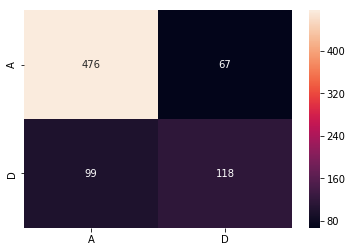

In [103]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(confusion_matrix(new_valid_y, y_pred), index = ['A','D'], columns = ['A','D']),
            annot=True, fmt='g')
plt.show()